##CIS 5450 Project: LSTM for APPL Stock Price Prediction

###Dataset###

AAPL.US_M30.csv

https://www.kaggle.com/datasets/olegshpagin/usa-stocks-prices-ohlcv/data

###Initialization###

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
df = pd.read_csv("/content/AAPL.US_M30.csv")
df = df.tail(60000).reset_index(drop = True)

Display of raw data dataframe

In [57]:
raw_df = df.copy()
raw_df

,datetime,open,high,low,close,volume
0,2006-01-20 17:00:00,2.83,2.84,2.78,2.79,36361003
1,2006-01-20 17:30:00,2.79,2.80,2.77,2.78,29311457
2,2006-01-20 18:00:00,2.78,2.79,2.76,2.77,18668951
3,2006-01-20 18:30:00,2.77,2.78,2.75,2.76,21244111
4,2006-01-20 19:00:00,2.76,2.77,2.75,2.76,11433359
...,...,...,...,...,...,...
59995,2024-03-13 21:00:00,171.50,171.76,171.44,171.58,1555153
59996,2024-03-13 21:30:00,171.58,171.80,171.51,171.65,1344467
59997,2024-03-13 22:00:00,171.65,171.74,171.03,171.29,2068274
59998,2024-03-13 22:30:00,171.28,171.71,171.04,171.15,4250264


Plotting the time series data (Note this is for 30 minute intervals)

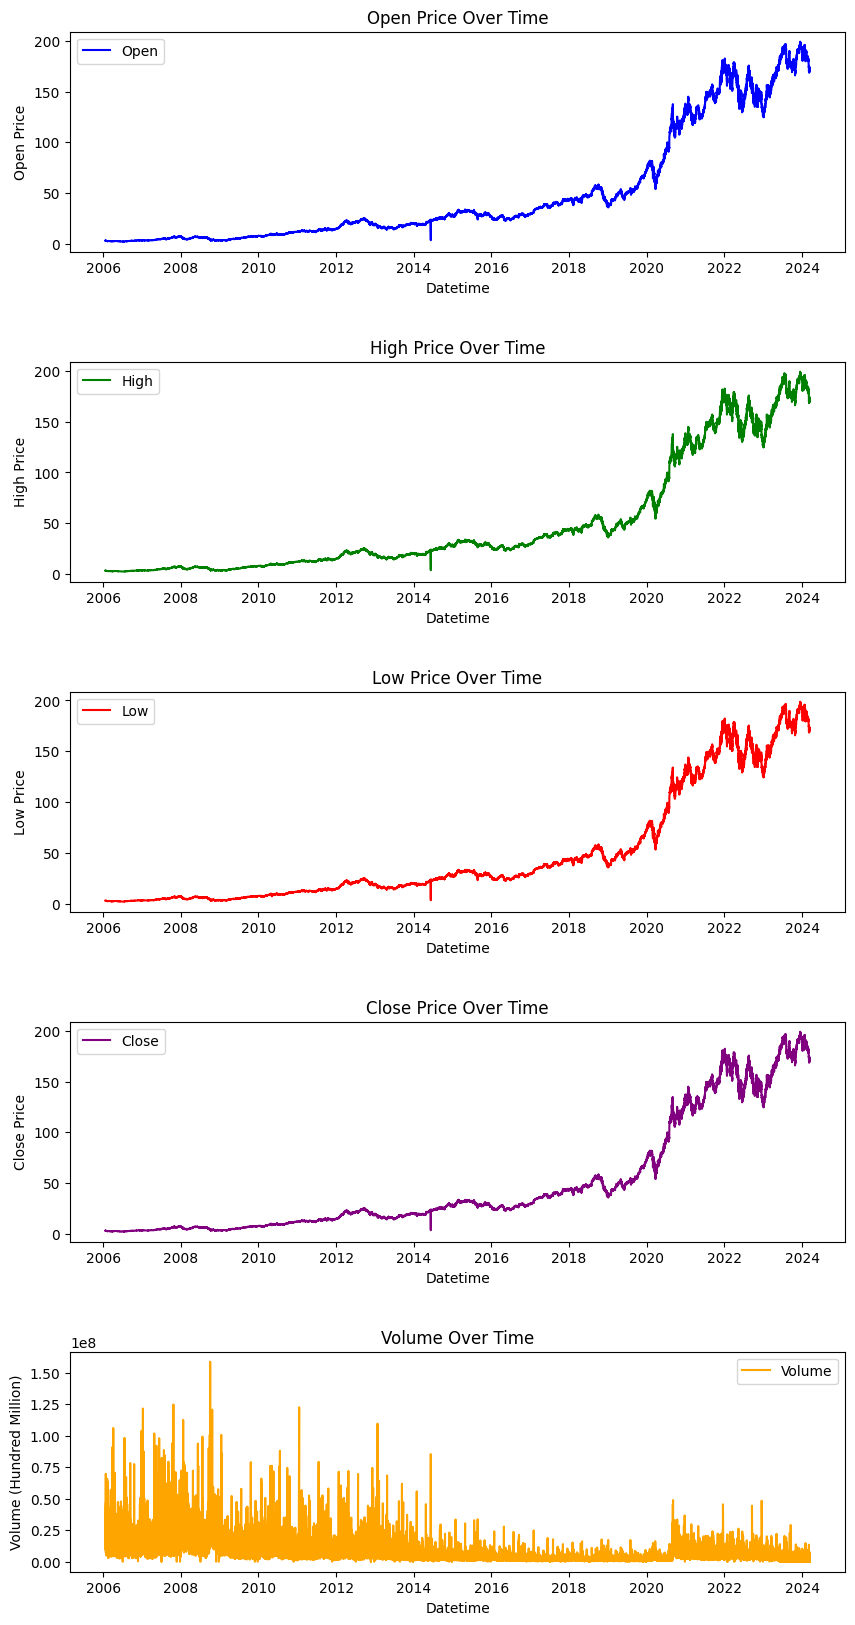

<Figure size 500x2000 with 0 Axes>

In [58]:
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'])

# Plotting each variable on separate plots
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.5)

axs[0].plot(raw_df['datetime'], raw_df['open'], label='Open', color='blue')
axs[0].set_title('Open Price Over Time')
axs[0].set_xlabel('Datetime')
axs[0].set_ylabel('Open Price')

axs[1].plot(raw_df['datetime'], raw_df['high'], label='High', color='green')
axs[1].set_title('High Price Over Time')
axs[1].set_xlabel('Datetime')
axs[1].set_ylabel('High Price')

axs[2].plot(raw_df['datetime'], raw_df['low'], label='Low', color='red')
axs[2].set_title('Low Price Over Time')
axs[2].set_xlabel('Datetime')
axs[2].set_ylabel('Low Price')

axs[3].plot(raw_df['datetime'], raw_df['close'], label='Close', color='purple')
axs[3].set_title('Close Price Over Time')
axs[3].set_xlabel('Datetime')
axs[3].set_ylabel('Close Price')

axs[4].plot(raw_df['datetime'], raw_df['volume'], label='Volume', color='orange')
axs[4].set_title('Volume Over Time')
axs[4].set_xlabel('Datetime')
axs[4].set_ylabel('Volume (Hundred Million)')

for ax in axs:
    ax.legend()

plt.figure(figsize=(5,20))
plt.show()

**Pairplot between each parwise group of features**

From the pairplot, note that by definition, the diagonals consist of histograms of a feature, whereas the off-diagonals consist of scatter plots plotting the partial correlation between two distinct features.

We can see that high, low, open and close are highly correlated with each other, but this is due to the fact that on average, the prices of AAPL stock during 30 minute intervals do not vary much, so there is a strong correlative relationship between these features. Therefore, in later consideration when training our algorithms, we will just select one of these features.

Additionally, because our high low open and close are also correlated, this indicates that AAPL stock volatility is relatively low in the short term.

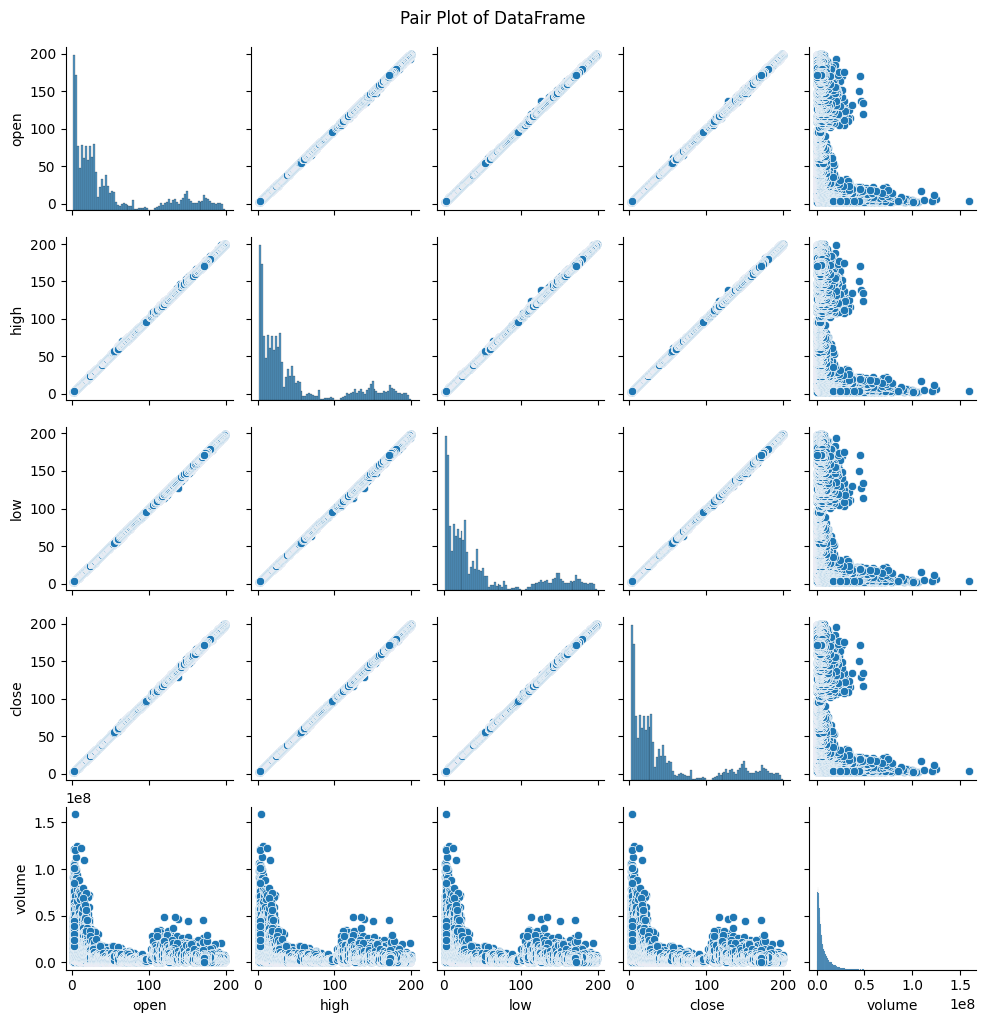

In [59]:
sns.pairplot(df, height=2)  # Decrease the height value to reduce the size of the plot

plt.suptitle("Pair Plot of DataFrame", y=1.02)  # Adjust the title location if needed
plt.show()

In [60]:
!pip install --upgrade mplfinance
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.3 MB/s eta 0:00:00


In [61]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=db150d2b01adfdc4c04436ab1939c525b6b85fe145d5b67fe0dbc02f33a5655b
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


Converting 30 minute plotted time series graph into a daily time series one.

In [62]:
daily_df = raw_df.copy()
daily_df['date'] = daily_df['datetime'].dt.date

daily_df['datetime'] = pd.to_datetime(daily_df['datetime'])

# Group by date and aggregate open, high, low, close, and volume
daily_df = daily_df.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).reset_index()

daily_df

,date,open,high,low,close,volume
0,2006-01-20,2.83,2.84,2.70,2.71,238513506
1,2006-01-23,2.71,2.84,2.71,2.77,253339408
2,2006-01-24,2.81,2.83,2.70,2.71,272217547
3,2006-01-25,2.76,2.76,2.61,2.65,308234003
4,2006-01-26,2.66,2.69,2.56,2.58,283050684
...,...,...,...,...,...,...
4610,2024-03-08,169.12,173.70,168.95,170.98,53335094
4611,2024-03-09,170.99,171.01,170.77,170.79,59796
4612,2024-03-11,172.94,174.38,172.05,172.75,44605588
4613,2024-03-12,173.15,174.03,171.01,173.21,37477359


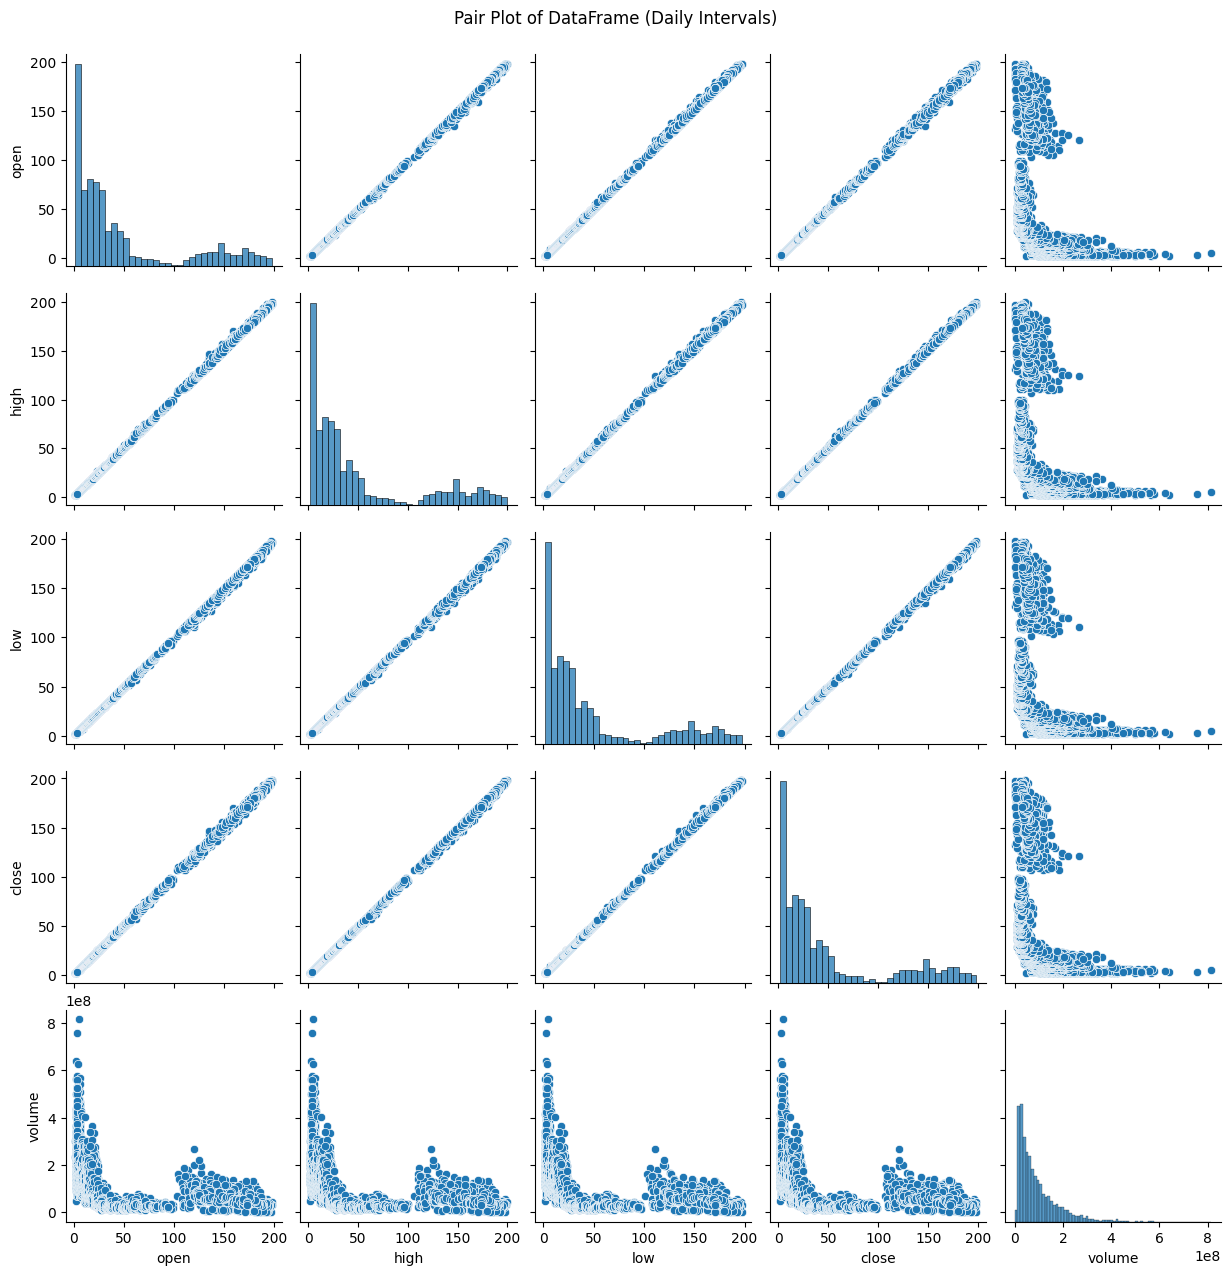

In [63]:
sns.pairplot(daily_df)

plt.suptitle("Pair Plot of DataFrame (Daily Intervals)", y=1.02)
plt.show()

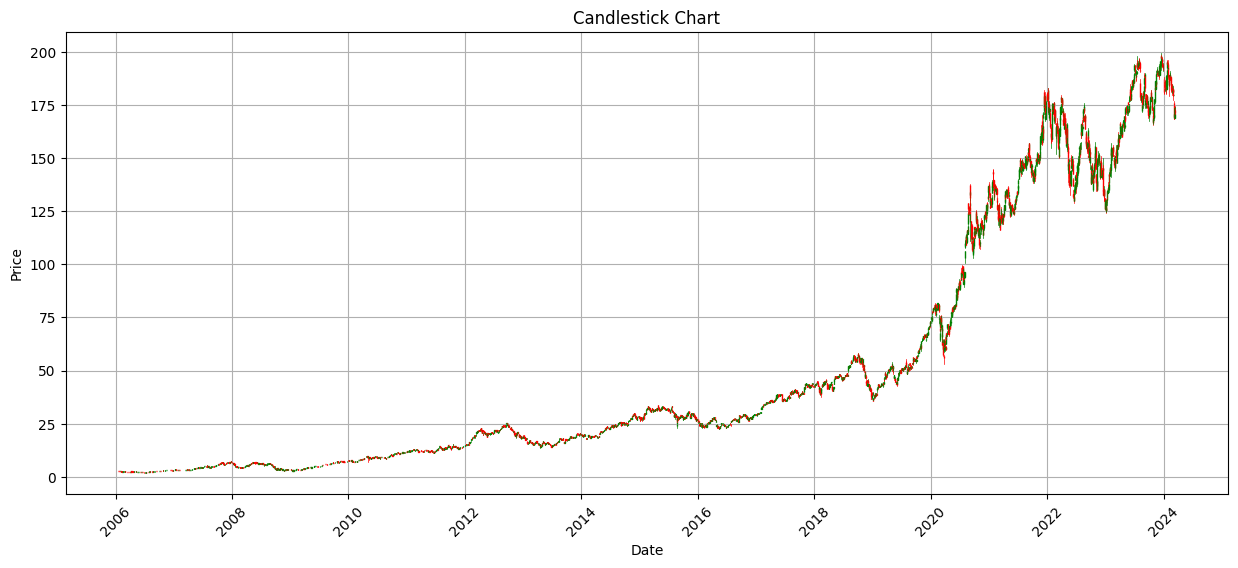

In [64]:
# Candlestick Chart

# Convert 'Date' column to matplotlib date format
matplotlib_date = mdates.date2num(daily_df['date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, daily_df['open'], daily_df['high'], daily_df['low'], daily_df['close'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

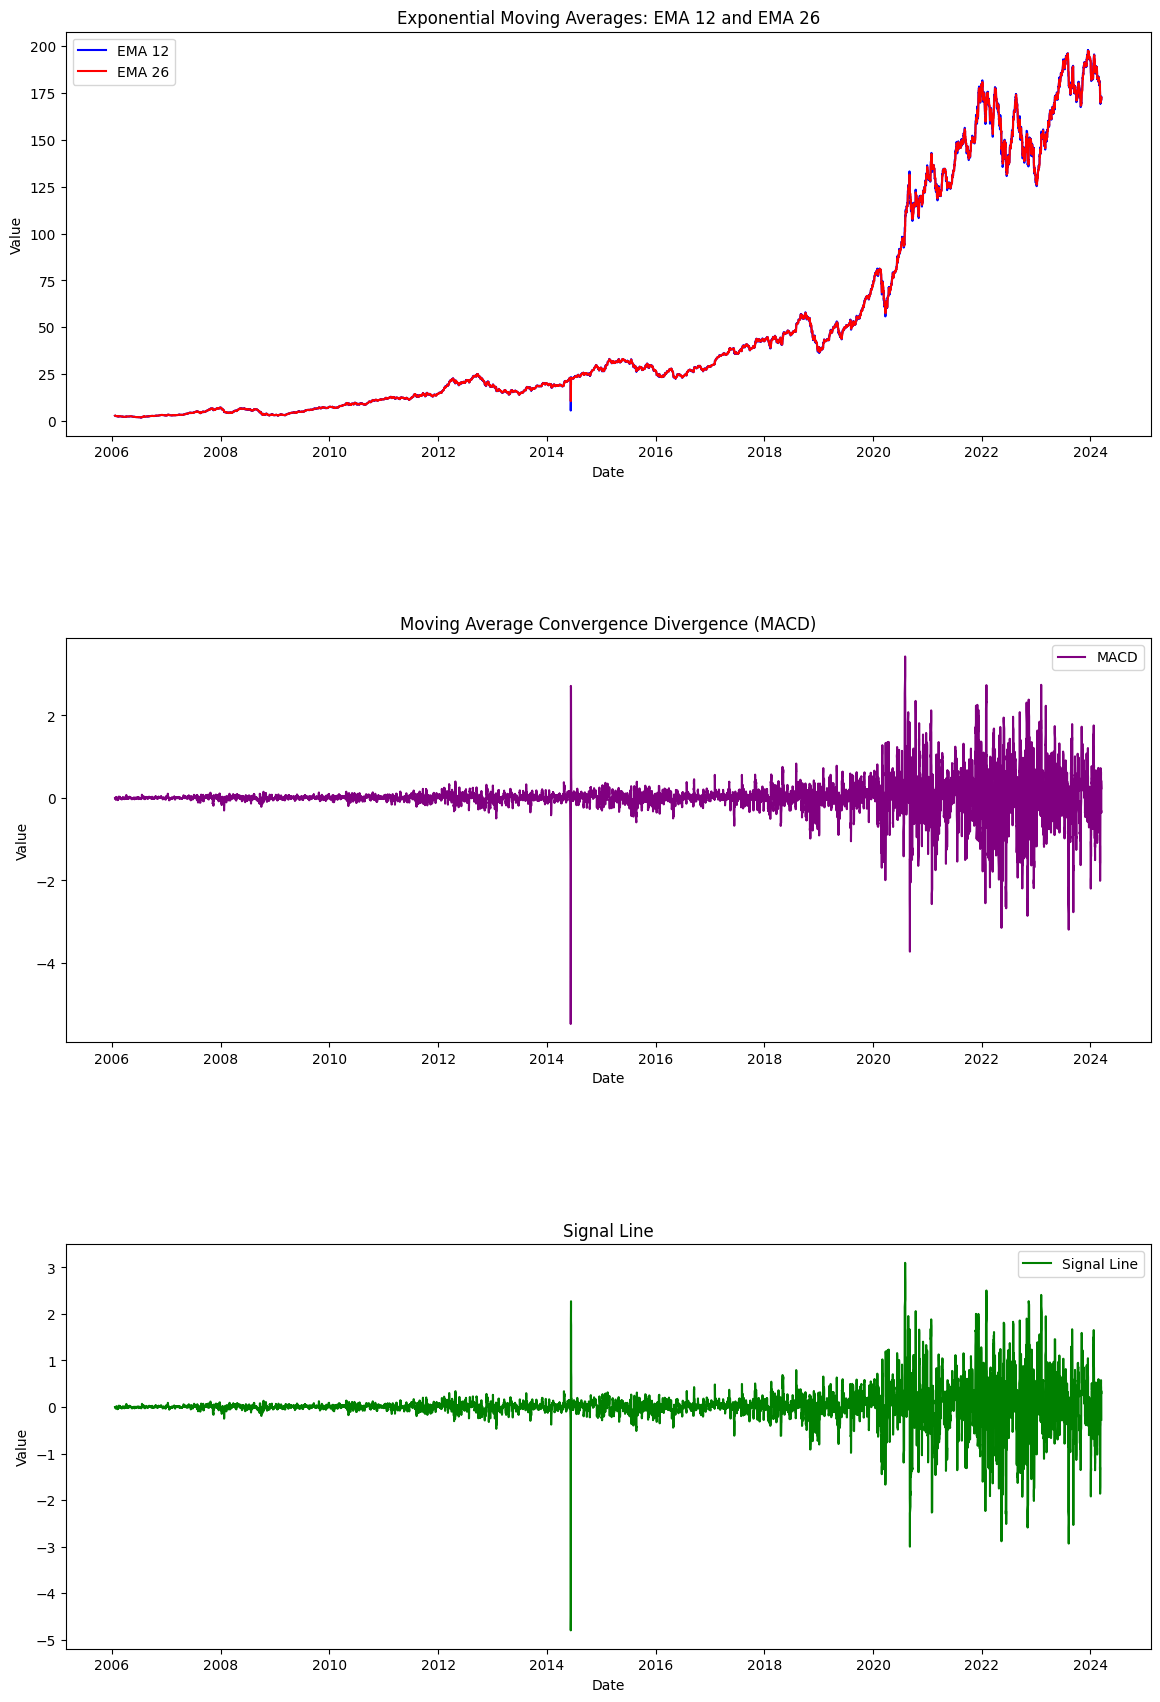

In [65]:
# Plotting EMA12, EMA26, MACD, and Signal Line in three separate graphs

# Calculate the Exponential Moving Averages for MACD
raw_df['EMA12'] = raw_df['close'].ewm(span=12, adjust=False).mean()
raw_df['EMA26'] = raw_df['close'].ewm(span=26, adjust=False).mean()

# Calculate the MACD and Signal line
raw_df['MACD'] = raw_df['EMA12'] - raw_df['EMA26']
raw_df['Signal'] = raw_df['MACD'].ewm(span=9, adjust=False).mean()

fig, axs = plt.subplots(3, 1, figsize=(14, 21))
fig.subplots_adjust(hspace=0.5)

# Plot EMA12 and EMA26
axs[0].plot(raw_df['datetime'], raw_df['EMA12'], label='EMA 12', color='blue')
axs[0].plot(raw_df['datetime'], raw_df['EMA26'], label='EMA 26', color='red')
axs[0].set_title('Exponential Moving Averages: EMA 12 and EMA 26')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Value')
axs[0].legend()

# Plot MACD
axs[1].plot(raw_df['datetime'], raw_df['MACD'], label='MACD', color='purple')
axs[1].set_title('Moving Average Convergence Divergence (MACD)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Value')
axs[1].legend()

# Plot Signal Line
axs[2].plot(raw_df['datetime'], raw_df['Signal'], label='Signal Line', color='green')
axs[2].set_title('Signal Line')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Value')
axs[2].legend()

plt.show()



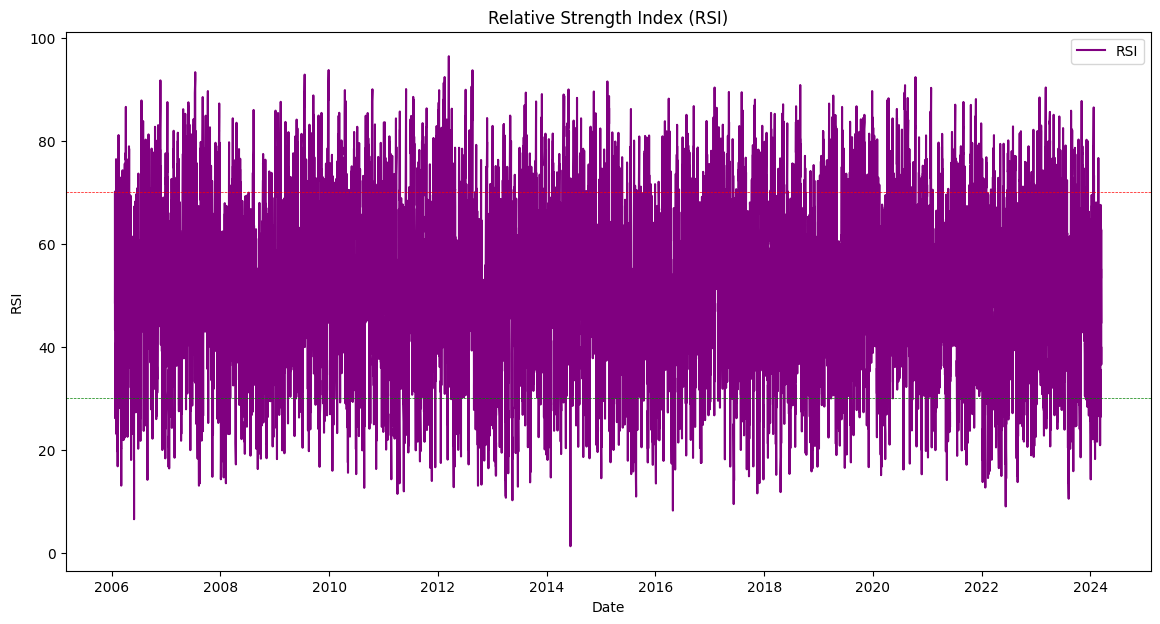

In [66]:
# Calculating the Relative Strength Index (RSI) for the 'close' price data

def calculate_rsi(data, window=14):
    # Compute price differences
    delta = data.diff()

    # Make two series: one for gains and one for losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    # Calculate the exponential moving average of gains and losses
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()

    # Calculate the RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI for the dataset
raw_df['RSI'] = calculate_rsi(raw_df['close'])

# Plotting the RSI
plt.figure(figsize=(14, 7))
plt.plot(raw_df['datetime'], raw_df['RSI'], label='RSI', color='purple')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(70, color='red', linestyle='--', linewidth=0.5)
plt.axhline(30, color='green', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


# **Data Visualizer **

In [67]:
from sklearn.linear_model import LinearRegression
from datetime import datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year  # Extract year for easy filtering

In [68]:
# Filter Data by Year Range
def filter_data_by_year(df, start_year, end_year):
    return df[(df['year'] >= start_year) & (df['year'] <= end_year)]

# User Input
def get_user_input():
    start_year = int(input("Enter the start year: "))
    end_year = int(input("Enter the end year: "))
    feature = input("Enter the feature to plot (open, high, low, close, volume): ")
    return start_year, end_year, feature

# Plot Data and Fit Linear Regression
def plot_data_with_regression(df, feature):
    plt.figure(figsize=(10, 5))
    plt.scatter(df['datetime'], df[feature], color='blue', label='Data Points')

    # Prepare data for linear regression
    X = np.array(df['datetime'].map(datetime.toordinal)).reshape(-1, 1)  # Convert dates to ordinal
    y = df[feature].values
    model = LinearRegression()
    model.fit(X, y)
    trend_line = model.predict(X)

    plt.plot(df['datetime'], trend_line, color='red', linewidth=2, label='Trend Line')
    plt.title(f'{feature.capitalize()} Trend from {df["year"].min()} to {df["year"].max()}')
    plt.xlabel('Date')
    plt.ylabel(feature.capitalize())
    plt.legend()
    plt.show()

In [69]:
def main():
    start_year, end_year, feature = get_user_input()
    filtered_df = filter_data_by_year(df, start_year, end_year)

    if not filtered_df.empty:
        plot_data_with_regression(filtered_df, feature)
    else:
        print("No data available for the selected year range.")

if __name__ == "__main__":
    main()

Enter the start year: 200
Enter the end year: 2001
Enter the feature to plot (open, high, low, close, volume): close
No data available for the selected year range.


#Data Preparation

In [ ]:
#normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['scaled_close'] = scaler.fit_transform(df[['close']])

In [ ]:
#prepare the sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Number of past records to consider
X, y = create_sequences(df['scaled_close'], seq_length)

print(y)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Baseline Model: Simple Moving Average Predictor#

We made a simple moving average predictor as a baseline model, so that we can compare loss functions later on with the more complex models.

In [ ]:
# Assuming X and y are already defined as numpy arrays
def predict_average(X):
    # Compute the average for each sample across all features
    return np.mean(X, axis=1)

# Making predictions
y_pred = predict_average(X_train)

# Computing Mean Squared Error
mse = np.mean((y_train - y_pred)**2)

print(f"Mean Squared Error on Training Data: {mse}")

# Evaluating on the test set
y_pred_test = predict_average(X_test)
mse_test = np.mean((y_test - y_pred_test)**2)

print(f"Mean Squared Error on Test Data: {mse_test}")

In [70]:
#Baseline Model:

# Adjusting the SMA window to 5 periods (of 30 minutes) for the purpose of the example
raw_df['SMA_5'] = raw_df['close'].rolling(window=5).mean()

# The forecast for the next period is the last value of the SMA
next_point_prediction = raw_df['SMA_5'].iloc[-1]

# Display the predicted next closing price
next_point_prediction

171.358

# LSTM Network

For training, we decided to not use the train_test_split, but to chronologically split our data, with past data (approx. 80%) being our training data, and more recent data (approx. 20%) being our test data.

In [73]:
#build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))

In [75]:
loss, mse = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Mean Squared Error:", mse)

375/375 [==============================] - 4s 8ms/step - loss: 1.0682e-04 - mse: 1.0682e-04
Loss: 0.00010682169522624463
Mean Squared Error: 0.00010682169522624463


In [76]:
predictions = model.predict(X_test)
print(predictions)  # Inverse transform to get actual values

375/375 [==============================] - 3s 5ms/step
[[0.56288904]
 [0.5629218 ]
 [0.56264794]
 ...
 [0.86413753]
 [0.86386245]
 [0.8636305 ]]


In [77]:
print(y_test)

[0.55040527 0.54721378 0.54528875 ... 0.86043566 0.85861196 0.85790274]


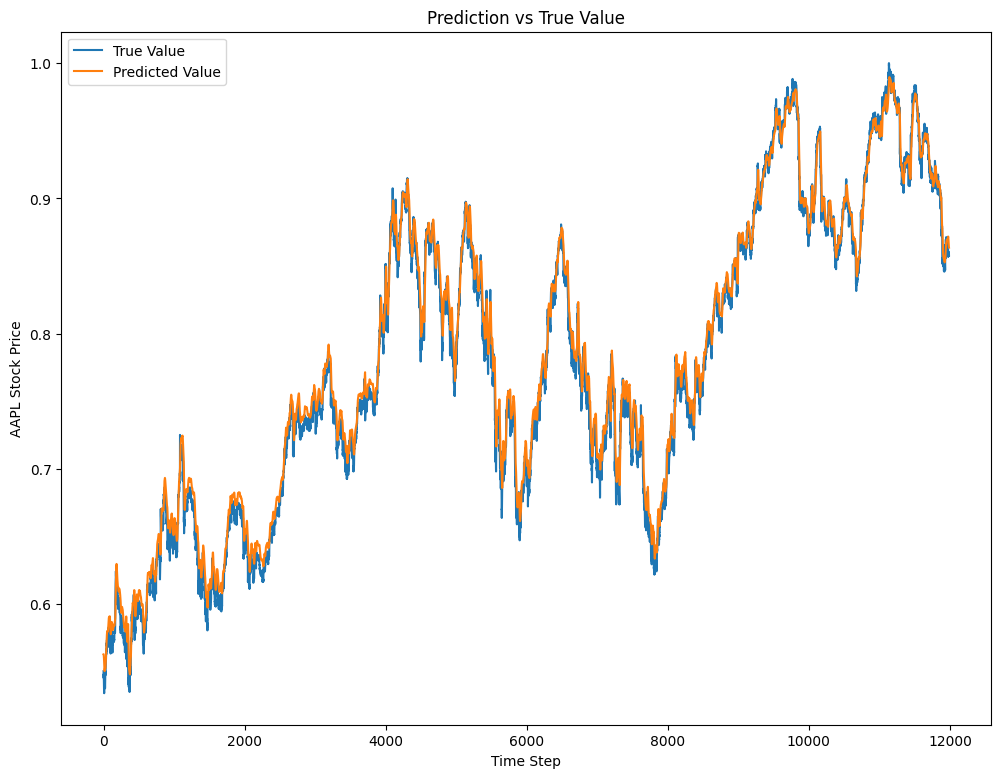

In [78]:
plt.figure(figsize=(12, 9))
# This plot shows our mdoels performance on AAPL test data

plt.plot(y_test, label='True Value')
plt.plot(predictions, label='Predicted Value')
plt.title('Prediction vs True Value')
plt.xlabel('Time Step')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

# Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
n_estimators_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
errors = []

for n_estimators in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    errors.append(mse)
    print(f"Number of Estimators: {n_estimators}, MSE: {mse}")


Number of Estimators: 10, MSE: 0.025200745128771407
Number of Estimators: 50, MSE: 0.024244137347075558
Number of Estimators: 100, MSE: 0.024392284917014243
Number of Estimators: 150, MSE: 0.024305048401583953
Number of Estimators: 200, MSE: 0.024298774715277024
Number of Estimators: 250, MSE: 0.02428519564252548
Number of Estimators: 300, MSE: 0.024212698772958244
Number of Estimators: 350, MSE: 0.024211195928796402


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, errors, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Number of Estimators on MSE')
plt.grid(True)
plt.show()

#PCA Features for Prediction

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'daily_df' contains features like 'open', 'high', 'low', 'close', 'volume'
features = daily_df[['open', 'high', 'low', 'close', 'volume']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=3)  # Choosing 3 components for illustration
principal_components = pca.fit_transform(features_scaled)
daily_df[['PC1', 'PC2', 'PC3']] = principal_components

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data.iloc[i:(i + seq_length)].values  # Selecting PCA features
        y = data.iloc[i + seq_length]  # This could be your target variable
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Assuming 'close' is the target and is outside of the PCA features
pca_features = daily_df[['PC1', 'PC2', 'PC3']]
target = daily_df['close'].shift(-1)  # Predict next day's close price

# Prepare sequences
seq_length = 60  # Number of past records to consider
X, y = create_sequences(pca_features, seq_length)

In [ ]:
from sklearn.model_selection import train_test_split

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Flatten the sequence data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Now the data should be two-dimensional
print(X_train_reshaped.shape)  # Should print (samples, features*sequence_length)

# Train the RandomForestRegressor with the reshaped data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, y_train)  # Use the reshaped training data
y_pred = model.predict(X_test_reshaped)  # Predict using the reshaped test data

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Convert the 'date' column to datetime type and set it as the index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Work with the 'close' prices
data = df['close']

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Dickey-Fuller test
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Check stationarity
test_stationarity(data)

In [ ]:
# Differencing the data if necessary
data_diff = data.diff().dropna()
test_stationarity(data_diff)

In [ ]:
# Split the data into train and test sets (80% train, 20% test)
split_point = int(len(data_diff) * 0.8)
train_data, test_data = data_diff[:split_point], data_diff[split_point:]

In [ ]:
# Fit the ARIMA model
model = ARIMA(train_data, order=(1,1,1))  # Example: 1st order autoregressive model with 1st order differencing
results = model.fit()

# Summary of the model
print(results.summary())

In [ ]:
# Predict future values
predictions = results.forecast(steps=len(test_data))
print(predictions)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data_diff, label='Original')
plt.plot(predictions, label='Predicted', color='red')
plt.legend(loc='best')
plt.show()

#Project Summary

**Problem Statement:** We are in a regression setting, trying to predict the next price of a stock given the previous price data of the stock. We chose Apple Stock 30-minute dataset over its lifetime because Apple is an important stock which many investors have a keen interest in, and it has some variance but isn't (visually, and as we've found) unpredictably variant.

**Dataset:** The dataset is a 30-minute interval Apple stock price dataset, with each interval containing high, low, open, and close prices on the interval as well as volume of stock exchanged over that interval.
Based on the actual application of our model, namely to predict stock prices, we made the decision to convert our data to daily instead of thirty-minute intervals, as learning daily prices would give investors more long-term and applicable predictions which they can make more impactful decisions on.


**EDA:** Our EDA was quite expansive and showed many different approaches to visualizing the data. We created time-series plots for datapoint open close, high, low, and volumes, we created Pairplots both on the thirty-minute dataset, then on the converted daily dataset we plotted EMA12 and EMA26 (which are exponential moving averages of 12 and 26 datapoints), MACD of these two (Moving Average Convergence Divergence) which shows whether bullish/bearish trends are strengthening/weakening, and Signal Line (9-day exponential moving average of the MACD), and lastly the Relative Strength Index (RSI) (speed and change of price movement), which are all very powerful stock visualization methods used by experts.  


**Approach:** We first made a baseline regression model which simply took the average of all datapoints. Then, for our actual models, we created an LSTM Network, a Random Forest regressor, a PCA-feature Random Forest regressor, and an ARIMA model. For LSTM, we tested various hyperparameters such as size of hidden layers and found our current setup to be optimal. Moreover, for Random Forest we plotted the various losses at different number of estimators from 10 to 100, and found 30 to be the most reliable, which is why we used 30 regressors in our PCA random forest. Moreover, PCA learns a smaller dimensional space to represent the data, and thus we realized we could assists the regressor model by selecting only the most import featured through this preprocessing with PCA unsupervised learning method.

**Results:**
We used multiple models to find various methods of prediction, and based on the most reliable performance metric-- model loss -- our LSTM network performed the best and could predict price with quite high accuracy on test data (in the _e^-5 range). However, our Random Forest model is more interperetable as a model class, which can be more beneficial to some users.

**Conclusion and Discussion:** PCA was quite useful for Random Forest, which is a naturally interperetable model.

For LSTM, we found a nice sweet spot in terms of hidden layer size based on training time, overfitting, and underfitting. In terms of accurate results, users would likely prefer to use the LSTM over any other models. The model does take a nontrivial amount of time and GPU compute to train, especially compared to the others, however.

In the future we could consider adding an RNN to see how it compares to the LSTM, as RNNs are known to function well on time-series data (as are LSTMs)